<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/R11_FCNN_CNN_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-545 Recitation 9 - Neural Networks in PyTorch

There are various libraries in Python to do Deep Learning such as, [PyTorch](https://pytorch.org/docs/stable/index.html), [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) and [MxNet](https://mxnet.apache.org/versions/1.9.1/api). We can also use other libraries with built-in automatic differentiation such as [Jax](https://jax.readthedocs.io/en/latest/index.html) and its Deep Learning counterpart [Flax](https://flax.readthedocs.io/en/latest/)!

For the context of this course, we will be working with PyTorch - an open-source easy to use library. 

## Loading Dependecies

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchinfo import summary

# Setting the device to do computations on - GPU's are generally faster!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

1.13.1+cu116
cuda


## Torch Tensors and Computational Graphs

PyTorch has its own data structure to facilitate computing on CPU/GPU as well use automatic differentiation for backpropagation.

In [ ]:
# Initialize a 2D torch tensor with ones of size 5 x5
ones_matrix = torch.ones((5, 5))

# Intialize a vector with ones of size 5 x 1
ones_vector = torch.ones((5, 1))


In [ ]:
# Matrix-vector multiplication with PyTorch
torch.matmul(ones_matrix, ones_vector)

tensor([[5.],
        [5.],
        [5.],
        [5.],
        [5.]])

In [ ]:
ones_matrix @ ones_vector

tensor([[5.],
        [5.],
        [5.],
        [5.],
        [5.]])

For people familiar with NumPy, there are similar functions that operate on torch tensors, to almost every function in NumPy that operate on NumPy N-d arrays.

However, apart from GPU support PyTorch also offers something else that is extremely important in designing Neural Networks.

Let's consider a 5 x 5 - matrix $A$ and a 5 x 1 - vector $b$. We will compute $l$ as given:

\begin{gather*}
  z = A \cdot b \\
  l = \sum_{i=1}^{5} z_{i}
\end{gather*}

We can now actually calculate gradients:

\begin{gather*}
  \left( \frac{\partial l}{\partial b} \right)_{i} = \sum_{j=1}^{5} A_{ji}
\end{gather*}

In [ ]:
tensor_A = torch.rand((5, 5))
tensor_A.requires_grad = True
tensor_b = torch.rand((5, 1))
tensor_b.requires_grad = True

l_var = torch.sum(tensor_A @ tensor_b) 

In [ ]:
l_var.backward()

In [ ]:
# Torch autograd
tensor_b.grad

tensor([[2.8218],
        [2.1581],
        [2.9693],
        [1.8479],
        [3.1973]])

In [ ]:
# Expected gradient
torch.sum(tensor_A, axis=0).detach().reshape((-1, 1))

tensor([[2.8218],
        [2.1581],
        [2.9693],
        [1.8479],
        [3.1973]])

## Load the Dataset

### PyTorch supports a lot of inbuilt datasets to play around with. In this recitation, we will be working with the famous [MNIST](https://en.wikipedia.org/wiki/MNIST_database#:~:text=The%20MNIST%20database%20(Modified%20National,the%20field%20of%20machine%20learning.) dataset.


Documentation to load the MNIST dataset from torchvision can be found [here](https://pytorch.org/vision/stable/datasets.html).

<img src='https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png'>

First, we load the dataset from torchvision.

In [ ]:
mnist_dataset = torchvision.datasets.MNIST('./', download=True, train=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Visualising the dataset


In [ ]:
# Look at all the class labels
mnist_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

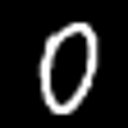

Label: 0


In [ ]:
# Looking at the images
idx = 1000

datapoint = mnist_dataset[idx]
datapoint[0].resize([128, 128]).show()
print('Label:', datapoint[1])

In [ ]:
# Size and shape of our training data
mnist_dataset.data.shape

torch.Size([60000, 28, 28])

## Transforms and Dataloaders

Torchvision Transforms are a neat way to preprocess image data before passing it to our neural networks. We will be using transforms for normalizing our data and converting them to torch tensors.

However, transforms are often also used for data augmentation in PyTorch. Something that you can find very useful while training Neural Networks in practice, such as in your final projects!

You can find the Torchvosion documentation on transforms [here](https://pytorch.org/vision/0.9/transforms.html).

In [ ]:
# We could see what our data mean and variance are, and scale accordingly 
# - However we don't really need to worry too much about this here! Any idea why?

transforms = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize([0.5], [0.5])])

In [ ]:
train_data = torchvision.datasets.MNIST('./', train=True, transform=transforms)
test_data = torchvision.datasets.MNIST('./', train=False, transform=transforms)

Dataloaders facilitate how our network consumes the data while training. Often optimisation algorithms such as Mini-batch Gradient Descent in Deep Learning, train data in batches. We can also choose whether to shuffle the data on each iteration, 

In [ ]:
# Batch-size - a hyperparameter
batch = 64

train_loader = DataLoader(train_data, batch_size = batch, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch, shuffle = False)

## A basic fully-connected Neural Network

To define models in PyTorch we make use of the torch.nn module. It has all the common layers and activation functions built in. 

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # To flatten your images as vectors so that FCNN can read them
        self.flatten = nn.Flatten()

        # We will be using activation functions
        self.relu = nn.ReLU()
        
        # Hidden and output layers
        self.input = nn.Linear(28 * 28, 256)
        self.hidden2 = nn.Linear(256, 64)
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        outputs = nn.Sequential(self.flatten, self.input, self.relu, self.hidden2, self.relu, self.output)(x)
        return outputs

In [ ]:
# Initialize model and check out its summary
model_fcnn = FCNN().to(device)
summary(model_fcnn, (batch, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
FCNN                                     [64, 10]                  --
├─Flatten: 1-1                           [64, 784]                 --
├─Linear: 1-2                            [64, 256]                 200,960
├─ReLU: 1-3                              [64, 256]                 --
├─Linear: 1-4                            [64, 64]                  16,448
├─ReLU: 1-5                              [64, 64]                  --
├─Linear: 1-6                            [64, 10]                  650
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
Total mult-adds (M): 13.96
Input size (MB): 0.20
Forward/backward pass size (MB): 0.17
Params size (MB): 0.87
Estimated Total Size (MB): 1.24

Training the model:

In order to train the model we need to decide on a loss function and set an optimizer. For a multi-class classification, we typically use the [Cross-Entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
criterion = nn.CrossEntropyLoss()

Setting the Optimizer: We will use [Stochastic Gradient Descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) Optimizer to optimize our loss function while training. 

In [ ]:
# Learning rate - another hyperparameter

lr_fcnn = 0.001
optimizer_fcnn = optim.SGD(params=model_fcnn.parameters(), lr=lr_fcnn)

Training loop:

In [ ]:
num_epochs_fcnn = 10 # hyperparameter
losses_fcnn = []
accuracies_fcnn = []
train_size = len(train_data)

for epoch in range(num_epochs_fcnn): # Dataloader loop
  total_loss = 0 
  correct = 0
  for inputs, labels in train_loader:
    inputs = inputs.to(device) 
    labels = labels.to(device)
    outputs = model_fcnn(inputs)
    loss = criterion(outputs, labels)
    preds = torch.argmax(outputs, axis=1) # Predictions from the neural network output
    correct += (preds == labels).sum().item()
    total_loss += loss.item() * len(labels)

    # Extremely important! - to clear out gradients from previous iterations
    optimizer_fcnn.zero_grad()
    loss.backward()
    optimizer_fcnn.step()
  total_loss = total_loss / train_size
  accuracy = correct / train_size
  losses_fcnn.append(total_loss)
  accuracies_fcnn.append(accuracy)
  print("Epoch:", epoch+1, ", Loss:", round(total_loss, 4), ", Training Accuracy:", round(accuracy, 3))

Epoch: 1 , Loss: 2.2349 , Training Accuracy: 0.292
Epoch: 2 , Loss: 1.9765 , Training Accuracy: 0.634
Epoch: 3 , Loss: 1.5028 , Training Accuracy: 0.698
Epoch: 4 , Loss: 1.0516 , Training Accuracy: 0.768
Epoch: 5 , Loss: 0.7887 , Training Accuracy: 0.809
Epoch: 6 , Loss: 0.6455 , Training Accuracy: 0.833
Epoch: 7 , Loss: 0.561 , Training Accuracy: 0.85
Epoch: 8 , Loss: 0.5063 , Training Accuracy: 0.862
Epoch: 9 , Loss: 0.4682 , Training Accuracy: 0.87
Epoch: 10 , Loss: 0.4401 , Training Accuracy: 0.877


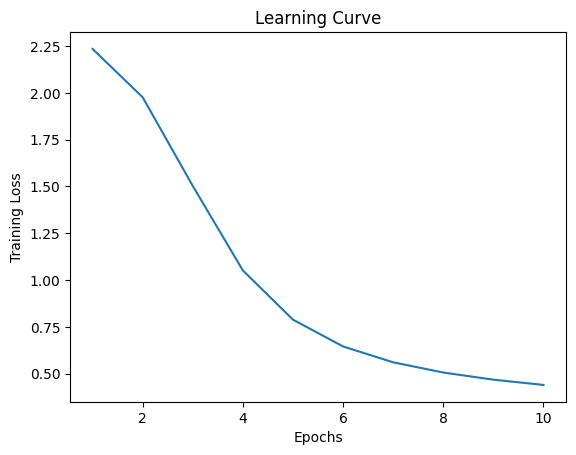

In [ ]:
plt.plot(range(1, num_epochs_fcnn + 1), losses_fcnn)
plt.title('Learning Curve')
plt.xlabel('Epochs')
_= plt.ylabel('Training Loss')

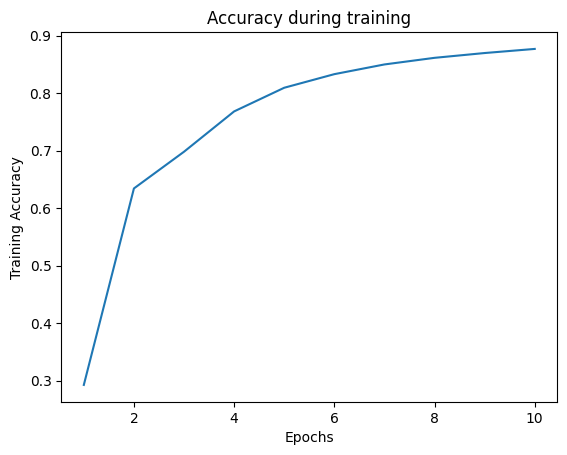

In [ ]:
plt.plot(range(1, num_epochs_fcnn + 1), accuracies_fcnn)
plt.title('Accuracy during training')
plt.xlabel('Epochs')
_= plt.ylabel('Training Accuracy')

In [ ]:
# Testing accuracy
test_size = len(test_data)
correct = 0

for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model_fcnn(inputs)
  preds = torch.argmax(outputs, axis=1)
  correct += (preds == labels).sum().item()

test_accuracy = correct / test_size

In [ ]:
print(test_accuracy)

0.8853



## Convolutional Neural Networks

Convolutional Neural Networks work by applying convolutional filters to the images. The output dimension of these layers depend on the various parameters such as filter size, padding and stride.

In each dimension of the image i.e. x or y:

\begin{gather*}
  o_{x} = \left \lfloor \frac{i_{x} + 2p_{x} - f_{x}}{s_{x}} \right \rfloor + 1
\end{gather*}

Similarly,

\begin{gather*}
  o_{y} = \left \lfloor \frac{i_{y} + 2p_{y} - f_{y}}{s_{y}} \right \rfloor + 1
\end{gather*}

Normally, we work with odd-sized, square-shaped kernels and have the padding as well as stride to have equal values in both dimensions.

The depth of the output convolutional block, i.e. number of channels is given by the number of filters used in the previous convolutional layer.

## Defining a CNN model on PyTorch

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Activation function
        self.relu = nn.ReLU()

        # Convolutional layer-1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2) # A same convolution
        
        # Pooling layer
        self.maxpool = nn.MaxPool2d(2)

        # Output size: 16 x 14 x 14

        # Convolutional layer-2: use 32, 3x3 filters
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        # Maxpool
        # Output size: 32 x 7 x 7
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.output = nn.Linear(32 * 7 * 7, 10)
        
    
    def forward(self, x):
        outputs = nn.Sequential(self.conv1, self.relu, self.maxpool,
                                self.conv2, self.relu, self.maxpool,
                                self.flatten, self.output)(x)
        return outputs

In [ ]:
train_data.data.shape[1:]

torch.Size([28, 28])

In [ ]:
# Initialize our CNN
cnn = CNN().to(device)
summary(cnn, (batch, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          416
├─ReLU: 1-2                              [64, 16, 28, 28]          --
├─MaxPool2d: 1-3                         [64, 16, 14, 14]          --
├─Conv2d: 1-4                            [64, 32, 14, 14]          4,640
├─ReLU: 1-5                              [64, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [64, 32, 7, 7]            --
├─Flatten: 1-7                           [64, 1568]                --
├─Linear: 1-8                            [64, 10]                  15,690
Total params: 20,746
Trainable params: 20,746
Non-trainable params: 0
Total mult-adds (M): 80.08
Input size (MB): 0.20
Forward/backward pass size (MB): 9.64
Params size (MB): 0.08
Estimated Total Size (MB): 9.92

## Train the CNN

In [ ]:
# Sending the data to device (CPU or GPU)
lr_cnn = 1e-4
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn.parameters(), lr=lr_cnn)

In [ ]:
num_epochs_fcnn = 10 # hyperparameter
losses_cnn = []
accuracies_cnn = []
train_size = len(train_data)

for epoch in range(num_epochs_fcnn):
  total_loss = 0
  correct = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = cnn(inputs)
    loss = criterion_cnn(outputs, labels)
    preds = torch.argmax(outputs, axis=1)
    correct += (preds == labels).sum().item()
    total_loss += loss.item() * len(labels)

    # Extremely important! - to clear out gradients from previous iterations
    optimizer_cnn.zero_grad()
    loss.backward()
    optimizer_cnn.step()
    
  total_loss = total_loss / train_size
  accuracy = correct / train_size
  losses_cnn.append(total_loss)
  accuracies_cnn.append(accuracy)
  print("Epoch:", epoch+1, ", Loss:", round(total_loss, 4), ", Training Accuracy:", round(accuracy, 3))

Epoch: 1 , Loss: 0.6913 , Training Accuracy: 0.843
Epoch: 2 , Loss: 0.1911 , Training Accuracy: 0.946
Epoch: 3 , Loss: 0.133 , Training Accuracy: 0.962
Epoch: 4 , Loss: 0.1051 , Training Accuracy: 0.969
Epoch: 5 , Loss: 0.0887 , Training Accuracy: 0.974
Epoch: 6 , Loss: 0.0783 , Training Accuracy: 0.977
Epoch: 7 , Loss: 0.0704 , Training Accuracy: 0.979
Epoch: 8 , Loss: 0.0645 , Training Accuracy: 0.981
Epoch: 9 , Loss: 0.0601 , Training Accuracy: 0.982
Epoch: 10 , Loss: 0.0561 , Training Accuracy: 0.983


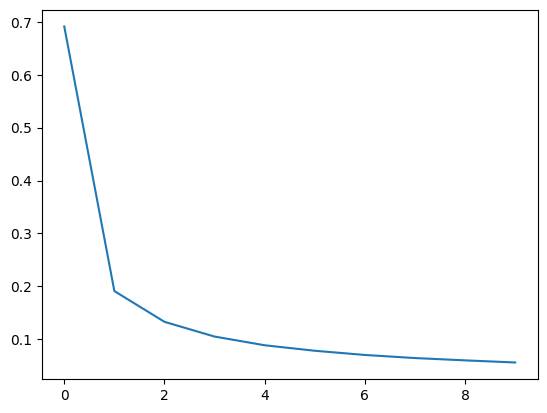

In [ ]:
plt.plot(losses_cnn)

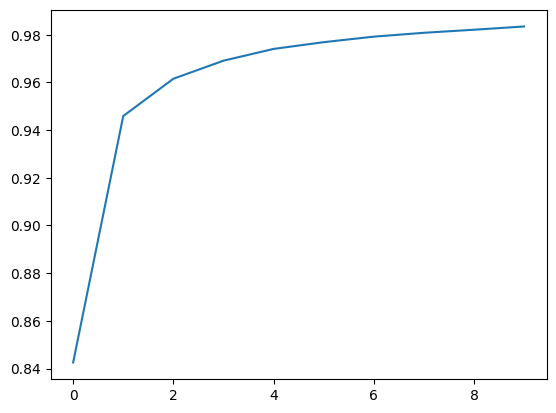

In [ ]:
plt.plot(accuracies_cnn)

## Calculating the Accuracy

In [ ]:
# Testing accuracy
test_size = len(test_data)
correct = 0

for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = cnn(inputs)
  preds = torch.argmax(outputs, axis=1)
  correct += (preds == labels).sum().item()

test_accuracy = correct / test_size

In [ ]:
print(test_accuracy)

0.9848


## Pre-defined Models in TorchVision

Torchvision provides predefined model architectures such as VGG-16, Resnet34, Resnet50 etc. You can use these model architectures and train them on new data or you can even use pretrained weights to do tasks on similar data. 

You can also use the pretrained models as templates and tweak them for your problem. This is called as transfer learning. It is extremely useful when we have limited data but also helps train models faster.

[Here](https://github.com/vsa1920/Facial-Recognition-with-Masks-using-One-shot-learning) is an example of it from my CIS-581 project, in case you are interested in learning more on how to use pretrained models and weights. 